<span style="font-size:35px; font-weight:bold; color:#03bafc;">
HEAL-Summ-Lite: Lightweight Health Summarization Pipeline
</span>

This notebook implements HEAL-Summ-lite, a lightweight summarization framework inspired by the HEAL-Summ methodology proposed by Dr. Fisher and colleagues ([2025](https://doi.org/10.3389/fpubh.2025.1619274)), using **three locally deployable LLMs**:

1. **Phi‑3.5 Mini (GGUF)** - aligned with HEAL-Summ's lightweight LLM approach.
2. **Apple OpenELM‑3B‑Instruct (GGUF)** - privacy-focused instruction-tuned model.
3. **FLAN‑T5‑Large (Transformers)** - instruction-tuned seq2seq model.

## Key Features Implemented

- Summaries strictly enforced to **120–180 words**.
- **Readability** computed using Flesch Reading Ease (FRE).  
- **Risk heuristics** include:  
  - Missing numbers (e.g., percentages, counts)  
  - Missing named entities (simple capitalized-word heuristic for institutions, researchers, key terms)  
  - Overconfident claims without uncertainty terms
- **Human review rule** triggers if readability < 50, any risk flag is raised, or summary is outside the 120–180 word range.
- Results are compiled in a **table**, saved as CSV, and visualized.
- **Lexical diversity** measured with Distinct‑1/2 metrics.
- Lightweight, local, reproducible, and aligned with HEAL-Summ-lite requirements.

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
SETUP
</span>
</div>

In [1]:
import os
import torch
import pandas as pd
import textstat
import re
import logging
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM
)
from nltk.util import ngrams
from collections import Counter
import numpy as np
from IPython.display import display, HTML

# plotting style
sns.set_theme(style="whitegrid")

In [2]:
# ==================== CONFIGURATION ====================
CONFIG = {
    "readability_threshold": 50,      # FRE < 50 triggers human review
    "max_words": 180,                  # target summary length
    "risk_checks": ["missing_numbers"], # active heuristics (can add more)
    "temperature": 0.3,                 # generation temperature
    "max_new_tokens": 250,               # approx token limit for summaries
    "intermediate_save": True,           # save per-model CSVs
}

# ==================== LOGGING ====================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [3]:
# Helper Functions

def readability_fre(text):
    """Return Flesch Reading Ease score."""
    return textstat.flesch_reading_ease(text)

def missing_numbers(original, summary):
    """Return True if original contains digits but summary does not."""
    orig_has_num = bool(re.search(r'\d', original))
    summ_has_num = bool(re.search(r'\d', summary))
    return orig_has_num and not summ_has_num

def missing_named_entities(original, summary, min_entity_threshold=3):
    """
    Flag if original contains several named entities
    but summary drops all of them.
    Uses simple capitalized-word heuristic.
    """
    orig_entities = set(re.findall(r'\b[A-Z][a-z]{2,}\b', original))
    summ_entities = set(re.findall(r'\b[A-Z][a-z]{2,}\b', summary))
    
    # Only apply if original contains enough candidate entities
    if len(orig_entities) >= min_entity_threshold:
        if len(orig_entities.intersection(summ_entities)) == 0:
            return True
    
    return False

def overconfident_claim(summary):
    """
    Flag if summary contains strong medical claims
    without uncertainty qualifiers.
    """
    strong_claim_patterns = [
        r'\bcures?\b',
        r'\beliminates?\b',
        r'\bprevents?\b',
        r'\bguarantees?\b',
        r'\bwill\b'
    ]
    
    uncertainty_terms = [
        "may", "might", "could", "suggests", "appears",
        "preliminary", "early", "potential", "possible"
    ]
    
    contains_strong_claim = any(re.search(p, summary.lower()) for p in strong_claim_patterns)
    contains_uncertainty = any(term in summary.lower() for term in uncertainty_terms)
    
    if contains_strong_claim and not contains_uncertainty:
        return True
    
    return False

def risk_flags(original, summary):
    """
    Return list of risk flags based on active checks.
    """
    flags = []
    
    # Missing numbers
    if missing_numbers(original, summary):
        flags.append("Missing numbers")
    
    # Missing named entities
    if missing_named_entities(original, summary):
        flags.append("Missing named entities")
    
    # Overconfident claims
    if overconfident_claim(summary):
        flags.append("Potential overconfident medical claim")
    
    return flags

def human_review_needed(readability, flags):
    """Return True if readability below threshold or any flags exist."""
    return readability < CONFIG["readability_threshold"] or len(flags) > 0

def enforce_length(summary, min_words=120, max_words=180):
    """
    Enforce 120–180 word constraint.
    Returns:
        summary (possibly trimmed),
        too_short (bool),
        too_long (bool)
    """
    words = summary.split()
    word_count = len(words)
    
    too_short = word_count < min_words
    too_long = word_count > max_words
    
    # Trim if too long
    if too_long:
        summary = " ".join(words[:max_words])
    
    return summary, too_short, too_long

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
DATA
</span>
</div>

In [ ]:
# Health Texts

texts = [
    {
        "source": "BBC",
        "title": "Single vaccine could protect against all coughs, colds and flus, researchers say",
        "text": """A single nasal spray vaccine could protect against all coughs, colds and flus, as well as bacterial lung infections, and may even ease allergies, say US researchers. The team at Stanford University have tested their "universal vaccine" in animals and still need to do human clinical trials. Their approach marks a "radical departure" from the way vaccines have been designed for more than 200 years, they say. Experts in the field said the study was "really exciting" despite being at an early stage and could be a "major step forward". Current vaccines train the body to fight one single infection. A measles vaccine protects against only measles and a chickenpox vaccine protects against only chickenpox. This is how immunisation has worked since Edward Jenner pioneered vaccines in the late 18th Century. The approach described in the journal Science does not train the immune system. Instead it mimics the way immune cells communicate with each other. It is given as a nasal spray and leaves white blood cells in our lungs – called macrophages – on "amber alert" and ready to jump into action no matter what infection tries to get in. The effect lasted for around three months in animal experiments. The researchers showed this heightened state of readiness led to a 100-to-1,000-fold reduction in viruses getting through the lungs and into the body. And for those that did sneak through, the rest of the immune system was "poised, ready to fend off these in warp speed time" said Prof Bali Pulendran, a professor of microbiology and immunology at Stanford. The team showed the vaccine also protects against two species of bacteria - Staphylococcus aureus and Acinetobacter baumannii. Pulendran told the BBC: "This vaccine, what we term a universal vaccine, elicits a far broader response that is protective against not just the flu virus, not just the Covid virus, not just the common cold virus, but against virtually all viruses, and as many different bacteria as we've tested, and even allergens. "The principle by which this vaccine works is a radical departure from the principle by which all vaccines have worked so far." The way it steers the immune system towards fighting an infection also seemed to reduce the response to house dust mite allergens – which are a trigger of allergic asthma. "This is a really exciting piece of research," says Prof Daniela Ferreira, a professor of vaccinology at University of Oxford, who was not involved in the study. She said it could "change how we protect people from common coughs, colds and other respiratory infections" if the results are confirmed in human studies. "One of the strengths" of the study was a clear explanation of how this new style of vaccine was working, she added. Ferreira said the research "could mark a major step forward" offering protection against infections that "place such a heavy burden" on us all. However, there are still many questions to answer. The vaccine was given as a nasal spray in the experiments, but may need to be breathed in through a nebuliser to reach the depths of human lungs. It is not known whether the same effect can be achieved in people or how long the immune system would stay in amber alert. There are differences in the immune systems between mice and humans, including our immunity being shaped by decades of infections. So the researchers are planning trials where one person is vaccinated and then deliberately infected to see how their body copes. There may also be consequences to dialling up the immune system beyond its normal state – raising questions of immune disorders. Jonathan Ball, professor of molecular virology at the Liverpool School of Tropical Medicine, said the work was undeniably "exciting" but cautioned "we have to ensure that keeping the body on 'high alert' doesn't lead to friendly fire, where a hyper-ready immune system accidentally triggers unwelcome side effects". The research team in the US does not think the immune system should be permanently dialled up and think such a vaccine should be used to complement rather than replace current vaccines. In the first stages of a pandemic, like early 2020 with Covid, a universal vaccine could buy time and save lives while a specialist vaccine was being developed. "That would reduce mortality, disease severity, and perhaps build up a level of immune resilience that would have a huge impact," says Pulendran. The other scenario is at the start of winter when the usual wide range of winter bugs start to spread, "one could imagine a seasonal spray that could be administered to imprint broad immunity" against them all. Correction 19 February: This story was updated after an earlier version referred to Edward Jenner using the title Sir, when in fact he was never knighted."""
    },
    {
        "source": "BBC",
        "title": "Hospital warns visitors about rising norovirus cases",
        "text": """A hospital ward has been closed and people have been urged to avoid visiting if they have recently had a bug after a rise in norovirus cases. Managers at West Suffolk Hospital in Bury St Edmunds have shut Ward F9 to new admissions and stepped up cleaning regimes across the site to prevent the spread of winter illnesses, including norovirus. They said they had seen more cases of norovirus, also known as the winter vomiting bug, at the hospital. Visitors have been advised not to go to the hospital if they have vomited or had diarrhoea, a high temperature, or a persistent dry cough in the last 48 hours. Patients have been asked to consider whether they could use NHS 111 or visit their GP or pharmacist. However, the hospital added that anyone needing emergency treatment should continue to go there. Staff at the NHS Suffolk and North East Essex Integrated Care Board (ICB), which plans and purchases local healthcare services, have also issued advice about the virus as it can rapidly spread. Lisa Nobes, the ICB's nursing director, said: "Every year there are cases in the community which transfer to the hospital. "Because the virus has an incubation period of several days, people are often unaware that they are carrying it until after they have passed it on. "Norovirus is spread by coming into contact with infected people or surfaces. If you have the symptoms of norovirus it is important you stay away from work or school and avoid socialising with others." Nobes added the best way for people to avoid catching the virus was to wash their hands properly, especially after using the toilet or handling food."""
    },
    {
        "source": "Harvard Health",
        "title": "Eating diverse flavonoid foods may provide extra health protection",
        "text": """Consuming large amounts of flavonoid-rich foods can help protect against various health conditions, including diabetes, cardiovascular disease, and certain types of cancer. But eating a diverse range of these foods may offer even greater health benefits than getting flavonoids from a few sources, according to a study published June 2, 2025, by Nature Food. Flavonoids are compounds that give plants their vibrant colors. High-flavonoid foods include tea, blueberries, strawberries, oranges, apples, grapes, plums, red cabbage, red wine, and dark chocolate. For the study, researchers tracked the eating habits of approximately 125,000 people ages 40 to 70 for more than a decade. Those with the highest diversity of flavonoid-rich foods in their diet showed a 20% lower risk of diabetes, a 10% lower risk of cardiovascular disease, and an 8% lower risk of cancer compared to people with the lowest diversity. People with the most diverse diets ate about seven different types of flavonoid-rich foods per day. The researchers pointed out that there are more than 6,000 types of flavonoids found in plants. Different ones offer specific benefits. For instance, some are better at improving blood pressure, while others help lower cholesterol or reduce inflammation. Therefore, it makes sense that consuming a range of high-flavonoid foods would provide a broader range of protection. While the study didn’t explore specific amounts, the researchers noted that other studies have shown health benefits associated with consuming at least 500 milligrams of flavonoids per day. This is equal to eating an apple, an orange, and a handful of berries and drinking two cups of tea."""
    },
    {
        "source": "Harvard Health",
        "title": "What is long QT syndrome?",
        "text": """With every heartbeat, the heart’s muscle cells are busy recharging themselves for the next contraction by moving sodium, potassium, and calcium through tiny pores on their surfaces. In long QT syndrome, these tiny pores don’t work correctly, or an electrolyte imbalance or another condition (such as a heart attack) causes the muscle to take longer than normal to recharge between beats. The resulting delay can disrupt the heart’s carefully choreographed timing. Most often a long QT interval does not cause symptoms; the heart compensates and continues to beat normally. But sometimes — perhaps because of physical or emotional stress — the delay pushes the heart into a fast, erratic heartbeat that may cause shortness of breath, fainting, and sometimes sudden death. Acquired long QT syndrome is more common than the congenital form, but the prevalence is difficult to estimate. A 2023 study suggests that women taking antibiotics and antipsychotic medications face the highest risk. But hundreds of commonly prescribed medications can cause long QT syndrome, including some of those used to treat heart disease, diabetes, depression, and allergies. CredibleMeds, a nonprofit organization funded in part by the FDA, provides a complete, updated list (registration is free for noncommercial entities). People who have inherited genetic variants associated with long QT are more likely to develop a drug-induced form of the syndrome. For people with drug-induced long QT syndrome, the QT delay usually disappears once the drug is stopped. At least one in 2,000 (possibly more) babies are born with congenital long QT syndrome each year. Although researchers have identified several different genes linked to long QT syndrome, mutations in just three of these genes account for up to 90% of inherited cases. Many people who have inherited long QT syndrome do not have any signs or symptoms and only find out they have the condition because of an ECG done for an unrelated reason. A close review of a person’s medical and family history can help uncover the diagnosis. It’s more likely among people with a history of recurring, unexplained fainting or near-fainting that occurs in response to vigorous exercise or a sudden loud noise. An exercise stress test, which involves further ECG testing, or wearing a portable ECG monitor can also be helpful to confirm the diagnosis."""
    },
    {
        "source": "News-Medical",
        "title": "Smarter timing of cancer treatments could improve cure rates, study suggests",
        "text": """A new study provides hope that smarter timing of cancer treatments could improve cure rates. The study's Principal Investigator, Dr Robert Noble, Senior Lecturer at the Department of Mathematics, City, St George's, University of London, sought to tackle a major problem in cancer care. Although tumors may at first shrink under therapy, in many cases they eventually regrow. These relapses stem from a small number of cancer cells that have gained mutations making the cells resistant to the treatment." Dr. Robert Noble, Senior Lecturer at the Department of Mathematics, City, St George's, University of London The standard clinical approach is to wait and see if a tumor regrows before trying a different treatment. By this point, some tumor cells are likely to have gained mutations making them resistant to the second treatment, which then also fails. Evolutionary theory suggests an alternative strategy. Instead of waiting, it might be better to switch to a second treatment while the tumor is still responding to the first one. This "kick it while it's down" approach is most appropriate when doctors know from experience that even the best option for a first treatment often fails due to resistance. Event guide: 3rd mRNA Process Development & Manufacturing Europe eBook This event guide is your go-to resource for the latest advancements in continuous mRNA processing. Download the latest edition As Dr Noble explains in a podcast about the study, "Evolutionary approaches have been very successful in other contexts, such as combatting antibiotic resistance, or predicting what vaccines we should use in a particular flu season. There is every reason to suppose that similar approaches should work in tumors." To test this hypothesis, Dr Noble and colleagues adapted mathematical methods more commonly used to understand how plants and animals evolve in response to environmental pressures, such as climate change. In their study, the team concludes that their findings justify further experimental and clinical testing of this innovative evolutionary treatment strategy. Three small clinical trials are already underway in soft-tissue cancer, prostate cancer, and breast cancer. Further trials are in development. "Our models predict that this new approach will generally outperform the standard of care," explains Dr Noble. "A sequence of two treatments, even if optimally timed, is likely to succeed only in relatively small tumors. But we have reason to hope that switching between three or more treatments, following the same principle, could eliminate larger tumors."""
    }
]

texts_df = pd.DataFrame(texts)
logging.info(f"Loaded {len(texts_df)} health texts.")

2026-02-23 00:39:36,182 - INFO - Loaded 5 health texts.


<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
MODELS
</span>
</div>

## Model 1: Phi‑3.5 Mini (Microsoft) – GGUF Quantized

In [ ]:
# Load Phi
 
from llama_cpp import Llama

phi_model_path = r"C:\Users\abedi\OneDrive\Desktop\HEALSummPrj\Phi_model\Phi-3.5-mini-instruct-Q4_K_M.gguf"

print("Loading Phi model (GGUF)...")

phi_model = Llama(
    model_path=phi_model_path,
    n_ctx=2048,
    n_threads=4,
    n_gpu_layers=0,
    verbose=False
)
print("Model loaded successfully!")

# With GGUF, there's no separate tokenizer, it's built into the model

Loading Phi model (GGUF)...


llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


Model loaded successfully!


In [6]:
# Phi Summarization Function

def phi_summarize(text, min_words=120, max_words=180):
    prompt = f"""Summarize the following health text in 120 to 180 words. 
Provide only the summary, no extra commentary.

Text: {text}

Summary:"""
    
    output = phi_model(
        prompt,
        max_tokens=250,
        temperature=0.3,
        stop=["\n\n", "Text:"],
        echo=False
    )
    
    summary = output["choices"][0]["text"].strip()
    
    # Enforce length
    summary, too_short, too_long = enforce_length(
        summary,
        min_words=min_words,
        max_words=max_words
    )
    
    return summary, too_short, too_long

In [7]:
# Generate Summaries with Phi

phi_results = []

for idx, row in tqdm(texts_df.iterrows(), total=len(texts_df), desc="Phi-3.5"):
    logging.info(f"Processing {row['title']} with Phi")
    
    summary, too_short, too_long = phi_summarize(row["text"])
    
    fre = readability_fre(summary)
    flags = risk_flags(row["text"], summary)
    
    if too_short:
        flags.append("Too short (<120 words)")
    if too_long:
        flags.append("Exceeded 180 words (trimmed)")
    
    review = human_review_needed(fre, flags)
    
    phi_results.append({
        "source": row["source"],
        "title": row["title"],
        "model": "Phi-3.5 Mini",
        "summary": summary,
        "readability_fre": round(fre, 2),
        "risk_flags": ", ".join(flags) if flags else "None",
        "human_review": "Yes" if review else "No"
    })

phi_df = pd.DataFrame(phi_results)

if CONFIG["intermediate_save"]:
    phi_df.to_csv("summaries_phi.csv", index=False)
    logging.info("Saved intermediate Phi results")
pd.set_option('display.max_colwidth', 500)

display(HTML(phi_df.to_html().replace('<table', '<table style="display:block; max-height:400px; overflow-y:auto"')))

Phi-3.5: 100%|██████████| 5/5 [03:19<00:00, 39.85s/it]
2026-02-23 00:42:57,292 - INFO - Saved intermediate Phi results


,source,title,model,summary,readability_fre,risk_flags,human_review
0,BBC,"Single vaccine could protect against all coughs, colds and flus, researchers say",Phi-3.5 Mini,"Researchers at Stanford University have developed a nasal spray vaccine that could potentially protect against all respiratory infections, including coughs, colds, flus, bacterial lung infections, and even allergies. This ""universal vaccine"" represents a significant shift from traditional vaccines, which target specific infections. The vaccine works by mimicking immune cell communication, keeping macrophages on high alert in the lungs, potentially reducing viral and bacterial penetration by up to 1,000-fold. Early animal trials suggest a three-month duration of effectiveness, with additional benefits against allergens. The research, though in early stages, has garnered excitement for its potential to revolutionize respiratory infection protection. However, questions remain regarding its application in humans, including delivery methods, duration of immune response, and safety, with plans for human trials involving deliberate infection to assess immune reaction. The researchers envision a complementary role for this vaccine, possibly as a seasonal spray to provide broad immunity against common respir",5.81,None,Yes
1,BBC,Hospital warns visitors about rising norovirus cases,Phi-3.5 Mini,"West Suffolk Hospital in Bury St Edmunds has closed Ward F9 due to a rise in norovirus cases, urging visitors to avoid the hospital if they've recently experienced symptoms like vomiting or diarrhea. The hospital has intensified cleaning and advises those with symptoms to seek alternative care, while emphasizing the importance of hand hygiene to prevent the spread of norovirus, which can be transmitted through contact with infected individuals or surfaces. The NHS Suffolk and North East Essex Integrated Care Board highlights the virus's incubation period and recommends staying home and practicing good handwashing to reduce transmission.",23.13,"Potential overconfident medical claim, Too short (<120 words)",Yes
2,Harvard Health,Eating diverse flavonoid foods may provide extra health protection,Phi-3.5 Mini,"A study highlights the health benefits of consuming a diverse array of flavonoid-rich foods, which are compounds that give plants their vibrant colors. Participants with the highest intake variety of these foods, averaging seven types per day, experienced a 20% reduced risk of diabetes, a 10% reduced risk of cardiovascular disease, and an 8% lower risk of cancer compared to those with the lowest variety. The research suggests that a broad range of flavonoids, exceeding the 6,000 types found in plants, provides comprehensive health protection, with benefits such as improved blood pressure, lower cholesterol, and reduced inflammation. Other studies indicate that consuming at least 500 milligrams of flavonoids daily, achievable through a combination of fruits, vegetables, and tea, is associated with health benefits.",30.50,None,Yes
3,Harvard Health,What is long QT syndrome?,Phi-3.5 Mini,"Long QT syndrome (LQTS) is a condition where the heart's muscle cells take longer than normal to recharge between beats due to malfunctioning pores or electrolyte imbalances, potentially leading to erratic heartbeats, shortness of breath, fainting, and sudden death. While most individuals with LQTS do not exhibit symptoms, certain medications, including some for heart disease, diabetes, depression, and allergies, can induce the condition. Women on antibiotics and antipsychotics are at higher risk. Genetic factors play a significant role, with three genes accounting for most inherited cases. Diagnosis often occurs incidentally through ECG tests or by evaluating medical and family history, particularly in individuals with a history of fainting triggered by physical exertion or loud noises. Drug-induced LQTS typically resolves after discontinuing the causative medication.",19.39,"Missing numbers,

In [8]:
# Free memory before loading next model
del phi_model
torch.cuda.empty_cache()
logging.info("Freed Phi model memory")

2026-02-23 00:42:58,160 - INFO - Freed Phi model memory


## Model 2: Apple OpenELM‑3B‑Instruct – GGUF Quantized

In [9]:
# Load Apple OpenELM

from llama_cpp import Llama

apple_model_path = r"C:\Users\abedi\OneDrive\Desktop\HEALSummPrj\Apple_model\OpenELM-3B-Instruct.Q4_K_M.gguf"

print("Loading Apple model (GGUF)...")
apple_model = Llama(
    model_path=apple_model_path,
    n_ctx=2048,          # context window
    n_threads=4,
    n_gpu_layers=0,
    verbose=False
)
print("Apple model loaded successfully!")

Loading Apple model (GGUF)...


llama_kv_cache_unified: the V embeddings have different sizes across layers and FA is not enabled - padding V cache to 768


Apple model loaded successfully!


In [10]:
# Apple Summarization Function

def apple_summarize(text, min_words=120, max_words=180):
    prompt = f"""Summarize the following health text in 120 to 180 words. 
Provide only the summary, no extra commentary.

Text: {text}

Summary:"""
    
    output = apple_model(
        prompt,
        max_tokens=250,
        temperature=0.3,
        stop=["\n\n", "Text:"],
        echo=False
    )
    
    summary = output["choices"][0]["text"].strip()
    
    # Enforce length
    summary, too_short, too_long = enforce_length(
        summary,
        min_words=min_words,
        max_words=max_words
    )
    
    return summary, too_short, too_long

In [11]:
# Generate Summaries with Apple

apple_results = []

for idx, row in tqdm(texts_df.iterrows(), total=len(texts_df), desc="Apple OpenELM"):
    logging.info(f"Processing {row['title']} with Apple")
    
    summary, too_short, too_long = apple_summarize(row["text"])
    
    fre = readability_fre(summary)
    flags = risk_flags(row["text"], summary)
    
    if too_short:
        flags.append("Too short (<120 words)")
    if too_long:
        flags.append("Exceeded 180 words (trimmed)")
    
    review = human_review_needed(fre, flags)
    
    apple_results.append({
        "source": row["source"],
        "title": row["title"],
        "model": "Apple OpenELM-3B",
        "summary": summary,
        "readability_fre": round(fre, 2),
        "risk_flags": ", ".join(flags) if flags else "None",
        "human_review": "Yes" if review else "No"
    })

apple_df = pd.DataFrame(apple_results)

if CONFIG["intermediate_save"]:
    apple_df.to_csv("summaries_apple.csv", index=False)
    logging.info("Saved intermediate Apple results")
pd.set_option('display.max_colwidth', 500)  # or a higher number
display(HTML(apple_df.to_html().replace('<table', '<table style="display:block; max-height:400px; overflow-y:auto"')))

Apple OpenELM: 100%|██████████| 5/5 [02:26<00:00, 29.39s/it]
2026-02-23 00:45:28,720 - INFO - Saved intermediate Apple results


,source,title,model,summary,readability_fre,risk_flags,human_review
0,BBC,"Single vaccine could protect against all coughs, colds and flus, researchers say",Apple OpenELM-3B,"A single nasal spray vaccine could protect against all coughs, colds and flus, as well as bacterial lung infections, and may even ease allergies, say US researchers. The team at Stanford University have tested their ""universal vaccine"" in animals and still need to do human clinical trials. Their approach marks a ""radical departure"" from the way vaccines have been designed for more than 200 years, they say. Experts in the field said the study was ""really exciting"" despite being at an early stage and could be a ""major step forward"". Current vaccines train the body to fight one single infection. A measles vaccine protects against only measles and a chickenpox vaccine protects against only chickenpox. This is how immunisation has worked since Edward Jenner pioneered vaccines in the late 18th Century. The approach described in the journal Science does not train the immune system. Instead it mimics the way immune cells communicate with each other. It is given as a nasal spray and leaves white blood cells",57.67,None,No
1,BBC,Hospital warns visitors about rising norovirus cases,Apple OpenELM-3B,"A hospital ward has been closed and people have been urged to avoid visiting if they have recently had a bug after a rise in norovirus cases. Managers at West Suffolk Hospital in Bury St Edmunds have shut Ward F9 to new admissions and stepped up cleaning regimes across the site to prevent the spread of winter illnesses, including norovirus. They said they had seen more cases of norovirus, also known as the winter vomiting bug, at the hospital. Visitors have been advised not to go to the hospital if they have vomited or had diarrhoea, a high temperature, or a persistent dry cough in the last 48 hours. Patients have been asked to consider whether they could use NHS 111 or visit their GP or pharmacist. However, the hospital added that anyone needing emergency treatment should continue to go there. Staff at the NHS Suffolk and North East Essex Integrated Care Board (ICB), which plans and purchases local healthcare services, have also issued advice about the virus as it can rapidly spread. Lisa Nobes, the ICB's nursing director",55.57,None,No
2,Harvard Health,Eating diverse flavonoid foods may provide extra health protection,Apple OpenELM-3B,"Eating a diverse range of flavonoid-rich foods, such as tea, blueberries, strawberries, oranges, apples, grapes, plums, red cabbage, red wine, and dark chocolate, may offer greater health benefits than getting flavonoids from a few sources. Foods rich in flavonoids include tea, blueberries, strawberries, oranges, apples, grapes, plums, red cabbage, red wine, and dark chocolate. For the study, researchers tracked the eating habits of approximately 125,000 people ages 40 to 70 for more than a decade. People with the highest diversity of flavonoid-rich foods in their diet showed a 20% lower risk of diabetes, a 10% lower risk of cardiovascular disease, and an 8% lower risk of cancer compared to people with the lowest diversity. People with the most diverse diets ate about seven different types of flavonoid-rich foods per day. The researchers noted that there are more than",53.52,None,No
3,Harvard Health,What is long QT syndrome?,Apple OpenELM-3B,"Long QT syndrome (LQTS) is a heart rhythm disorder that affects the electrical system of the heart. The electrical system coordinates the heart's contractions, ensuring that each heartbeat is synchronized with the next. Long QT syndrome occurs when the heart's electrical system takes longer than normal to recharge between heartbeats, resulting in an abnormally long pause (QT interval) on an electrocardiogram (ECG). This delay can disrupt the heart's normal rhythm, causing arrhythmias (irregular heartbeats) and sudden cardiac death. Acquired LQTS is more common than congenital LQTS, but its p

In [12]:
# Free memory
del apple_model
torch.cuda.empty_cache()
logging.info("Freed Apple model memory")

2026-02-23 00:45:29,053 - INFO - Freed Apple model memory


## Model 3: FLAN‑T5‑Large – Transformers (Full Version)

In [13]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

t5_model_path = r"C:\Users\abedi\OneDrive\Desktop\HEALSummPrj\T5_Transformer"

print("Loading FLAN-T5 tokenizer...")
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_path)

print("Loading FLAN-T5 model (this takes a minute)...")
t5_model = AutoModelForSeq2SeqLM.from_pretrained(
    t5_model_path,
    torch_dtype=torch.float16,  # Uses less RAM
    device_map="auto",
    low_cpu_mem_usage=True
)
print("FLAN-T5 model loaded successfully!")

Loading FLAN-T5 tokenizer...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading FLAN-T5 model (this takes a minute)...


Loading weights:   0%|          | 0/558 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


FLAN-T5 model loaded successfully!


In [14]:
# T5 Summarization Function

def t5_summarize(text, min_words=120, max_words=180):
    inputs = t5_tokenizer(
        "summarize: " + text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(t5_model.device)
    
    with torch.no_grad():
        summary_ids = t5_model.generate(
            inputs["input_ids"],
            max_new_tokens=250,
            min_length=80,
            num_beams=4,
            early_stopping=True,
            temperature=0.3,
            no_repeat_ngram_size=3
        )
    
    summary = t5_tokenizer.decode(
        summary_ids[0],
        skip_special_tokens=True
    )
    
    # Enforce length
    summary, too_short, too_long = enforce_length(
        summary,
        min_words=min_words,
        max_words=max_words
    )
    
    return summary, too_short, too_long

In [15]:
# Generate Summaries with T5

from tqdm import tqdm

t5_results = []

for idx, row in tqdm(texts_df.iterrows(), total=len(texts_df), desc="FLAN-T5"):
    logging.info(f"Processing {row['title']} with FLAN-T5")
    
    try:
        summary, too_short, too_long = t5_summarize(row["text"])
        
        fre = readability_fre(summary)
        flags = risk_flags(row["text"], summary)
        
        if too_short:
            flags.append("Too short (<120 words)")
        if too_long:
            flags.append("Exceeded 180 words (trimmed)")
        
        review = human_review_needed(fre, flags)
        
        t5_results.append({
            "source": row["source"],
            "title": row["title"],
            "model": "FLAN-T5-Large",
            "summary": summary,
            "readability_fre": round(fre, 2),
            "risk_flags": ", ".join(flags) if flags else "None",
            "human_review": "Yes" if review else "No"
        })
        
    except Exception as e:
        logging.error(f"Error: {e}")
        t5_results.append({
            "source": row["source"],
            "title": row["title"],
            "model": "FLAN-T5-Large",
            "summary": "[ERROR]",
            "readability_fre": 0,
            "risk_flags": "Error",
            "human_review": "Yes"
        })

t5_df = pd.DataFrame(t5_results)
t5_df.to_csv("summaries_t5.csv", index=False)
pd.set_option('display.max_colwidth', 500)

display(HTML(t5_df.to_html().replace('<table', '<table style="display:block; max-height:400px; overflow-y:auto"')))

FLAN-T5:   0%|          | 0/5 [00:00<?, ?it/s]2026-02-23 00:45:33,206 - INFO - Processing Single vaccine could protect against all coughs, colds and flus, researchers say with FLAN-T5
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
FLAN-T5: 100%|██████████| 5/5 [05:12<00:00, 62.42s/it]


,source,title,model,summary,readability_fre,risk_flags,human_review
0,BBC,"Single vaccine could protect against all coughs, colds and flus, researchers say",FLAN-T5-Large,"The vaccine could be a ""major step forward"" in immunisation, experts say, but it is still a long way from being approved by the FDA for use in humans, the BBC understands from a report in the Journal of the American Medical Association (JAMA) that the vaccine is still in the early stages of clinical trials and needs to be approved for human use.",11.01,"Missing numbers, Too short (<120 words)",Yes
1,BBC,Hospital warns visitors about rising norovirus cases,FLAN-T5-Large,"A ward at a hospital in Suffolk has been closed to new admissions following a rise in cases of the winter vomiting bug, the BBC has been told. The ward has also been stepped up in cleaning to prevent the spread of winter illnesses, including norovirus, which can be spread by contact with infected people or surfaces, NHS Suffolk and North East Essex Integrated Care Board said.",47.83,"Missing numbers, Potential overconfident medical claim, Too short (<120 words)",Yes
2,Harvard Health,Eating diverse flavonoid foods may provide extra health protection,FLAN-T5-Large,"Eating a diverse range of high-flavonoid foods may offer even greater health benefits than getting flavonoids from a few sources, according to a study published June 2, 2025, by Nature Food. Flavonoids are compounds that give plants their vibrant colors. They include tea, blueberries, strawberries, oranges, apples, grapes, plums, red cabbage, red wine, and dark chocolate.",60.99,Too short (<120 words),Yes
3,Harvard Health,What is long QT syndrome?,FLAN-T5-Large,Know the symptoms of long QT syndrome. Know the risk factors. Learn about drug-induced and inherited forms of the syndrome. Find out if you’re at risk for a congenital form of the condition. Ask your doctor about an exercise stress test (ECG) to determine whether you have inherited a form of a heart condition that causes a QT delay.,68.67,"Missing numbers, Missing named entities, Too short (<120 words)",Yes
4,News-Medical,"Smarter timing of cancer treatments could improve cure rates, study suggests",FLAN-T5-Large,"A new study provides hope that smarter timing of cancer treatments could improve cure rates. The study's Principal Investigator, Dr Robert Noble, Senior Lecturer at the Department of Mathematics, City, St George's, University of London, sought to tackle a major problem in cancer care. Although tumors may at first shrink under therapy, in many cases they eventually regrow. These relapses stem from a small number of cancer cells that have gained mutations making the cells resistant to the treatment.",41.15,"Missing numbers, Too short (<120 words)",Yes


In [16]:
# Free memory
del t5_model
del t5_tokenizer
torch.cuda.empty_cache()
logging.info("Freed FLAN-T5 model memory")

2026-02-23 00:50:45,818 - INFO - Freed FLAN-T5 model memory


In [17]:
# Combine all three models

all_results = pd.concat([phi_df, apple_df, t5_df], ignore_index=True)
all_results.to_csv("heal_summ_all_models.csv", index=False)
print(f"Combined {len(all_results)} results from 3 models")
display(all_results)

Combined 15 results from 3 models


,source,title,model,summary,readability_fre,risk_flags,human_review
0,BBC,"Single vaccine could protect against all coughs, colds and flus, researchers say",Phi-3.5 Mini,"Researchers at Stanford University have developed a nasal spray vaccine that could potentially protect against all respiratory infections, including coughs, colds, flus, bacterial lung infections, and even allergies. This ""universal vaccine"" represents a significant shift from traditional vaccines, which target specific infections. The vaccine works by mimicking immune cell communication, keeping macrophages on high alert in the lungs, potentially reducing viral and bacterial penetration by ...",5.81,None,Yes
1,BBC,Hospital warns visitors about rising norovirus cases,Phi-3.5 Mini,"West Suffolk Hospital in Bury St Edmunds has closed Ward F9 due to a rise in norovirus cases, urging visitors to avoid the hospital if they've recently experienced symptoms like vomiting or diarrhea. The hospital has intensified cleaning and advises those with symptoms to seek alternative care, while emphasizing the importance of hand hygiene to prevent the spread of norovirus, which can be transmitted through contact with infected individuals or surfaces. The NHS Suffolk and North East Esse...",23.13,"Potential overconfident medical claim, Too short (<120 words)",Yes
2,Harvard Health,Eating diverse flavonoid foods may provide extra health protection,Phi-3.5 Mini,"A study highlights the health benefits of consuming a diverse array of flavonoid-rich foods, which are compounds that give plants their vibrant colors. Participants with the highest intake variety of these foods, averaging seven types per day, experienced a 20% reduced risk of diabetes, a 10% reduced risk of cardiovascular disease, and an 8% lower risk of cancer compared to those with the lowest variety. The research suggests that a broad range of flavonoids, exceeding the 6,000 types found ...",30.50,None,Yes
3,Harvard Health,What is long QT syndrome?,Phi-3.5 Mini,"Long QT syndrome (LQTS) is a condition where the heart's muscle cells take longer than normal to recharge between beats due to malfunctioning pores or electrolyte imbalances, potentially leading to erratic heartbeats, shortness of breath, fainting, and sudden death. While most individuals with LQTS do not exhibit symptoms, certain medications, including some for heart disease, diabetes, depression, and allergies, can induce the condition. Women on antibiotics and antipsychotics are at higher...",19.39,"Missing numbers, Missing named entities",Yes
4,News-Medical,"Smarter timing of cancer treatments could improve cure rates, study suggests",Phi-3.5 Mini,"A study led by Dr. Robert Noble suggests that the timing of cancer treatments could be optimized by applying evolutionary theory, potentially improving cure rates. The research indicates that switching to a second treatment while the tumor remains responsive to the first could prevent the emergence of resistant cancer cells. This strategy, tested through mathematical models adapted from evolutionary biology, has shown promise in small clinical trials for various cancers. The findings suggest...",31.16,"Missing numbers, Too short (<120 words)",Yes
5,BBC,"Single vaccine could protect against all coughs, colds and flus, researchers say",Apple OpenELM-3B,"A single nasal spray vaccine could protect against all coughs, colds and flus, as well as bacterial lung infections, and may even ease allergies, say US researchers. The team at Stanford University have tested their ""universal vaccine"" in animals and still need to do human clinical trials. Their approach marks a ""radical departure"" from the way vaccines have been designed for more than 200 years, they say. Experts in the field said the study was ""really exciting"" despite being at an early st...",57.67,None,No
6,BBC,Hospital warns visitors about rising norovirus cases,Apple OpenELM-3B,"A hospital ward has been closed and people have been urged to avoid visiti

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
METRICS
</span>
</div>

In [18]:
# ==================== LEXICAL DIVERSITY METRICS ====================
def diversity_metrics(text):
    """Calculate Distinct-1 and Distinct-2 within a summary."""
    words = text.lower().split()
    if len(words) < 2:
        return {"distinct_1": 0.0, "distinct_2": 0.0}
    
    # Distinct-1: unique unigrams / total unigrams
    distinct_1 = len(set(words)) / len(words)
    
    # Distinct-2: unique bigrams / total bigrams
    bigrams = list(ngrams(words, 2))
    if len(bigrams) > 0:
        distinct_2 = len(set(bigrams)) / len(bigrams)
    else:
        distinct_2 = 0.0
        
    return {"distinct_1": distinct_1, "distinct_2": distinct_2}

# Apply to all summaries
print("Computing diversity metrics...")
diversity_results = all_results["summary"].apply(diversity_metrics).apply(pd.Series)
all_results["distinct_1"] = diversity_results["distinct_1"]
all_results["distinct_2"] = diversity_results["distinct_2"]
print("Done.")

Computing diversity metrics...
Done.


In [19]:
# ==================== EVALUATION METRICS ====================
print("\n" + "="*50)
print("EVALUATION METRICS")
print("="*50)

# Average readability per model
print("\n--- Average Readability (FRE) per Model ---")
avg_read = all_results.groupby("model")["readability_fre"].mean().round(2)
print(avg_read)

# Risk flag counts per model
print("\n--- Risk Flags Count per Model ---")
flag_counts = all_results.groupby("model")["risk_flags"].apply(lambda x: (x != "None").sum())
print(flag_counts)

# Average Distinct-1 per model
if "distinct_1" in all_results.columns:
    print("\n--- Average Distinct-1 (Lexical Diversity) per Model ---")
    avg_dist1 = all_results.groupby("model")["distinct_1"].mean().round(4)
    print(avg_dist1)


EVALUATION METRICS

--- Average Readability (FRE) per Model ---
model
Apple OpenELM-3B    46.28
FLAN-T5-Large       45.93
Phi-3.5 Mini        22.00
Name: readability_fre, dtype: float64

--- Risk Flags Count per Model ---
model
Apple OpenELM-3B    1
FLAN-T5-Large       5
Phi-3.5 Mini        3
Name: risk_flags, dtype: int64

--- Average Distinct-1 (Lexical Diversity) per Model ---
model
Apple OpenELM-3B    0.6991
FLAN-T5-Large       0.7834
Phi-3.5 Mini        0.7763
Name: distinct_1, dtype: float64


<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
VISUALIZATIONS
</span>
</div>

### Figure 1: Average Readability (FRE)

- This chart compares the average Flesch Reading Ease score per model. 
- Higher values indicate easier-to-read summaries. 
- The red dashed line marks the human review threshold.

C:\Users\abedi\AppData\Local\Temp\ipykernel_4160\2857160434.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=all_results, x="model", y="readability_fre", ci=None)


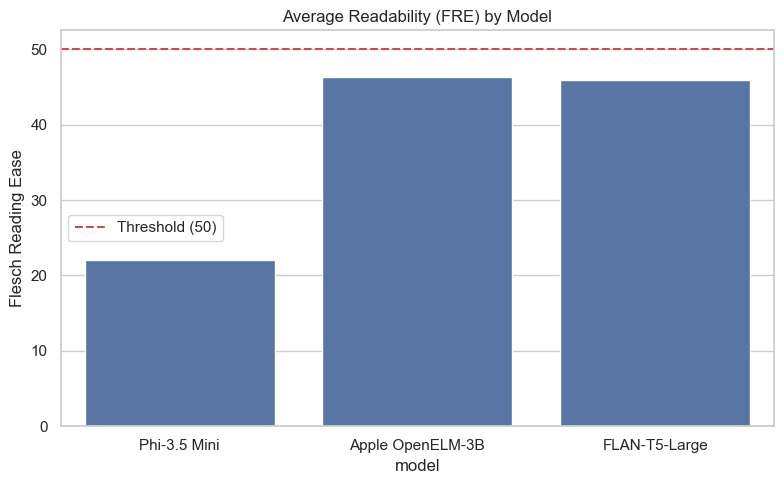

In [20]:
# 1. Bar chart: Average Readability
plt.figure(figsize=(8,5))
sns.barplot(data=all_results, x="model", y="readability_fre", ci=None)
plt.title("Average Readability (FRE) by Model")
plt.ylabel("Flesch Reading Ease")
plt.axhline(y=CONFIG["readability_threshold"], color='r', linestyle='--', label=f"Threshold ({CONFIG['readability_threshold']})")
plt.legend()
plt.tight_layout()
plt.savefig("avg_readability.png", dpi=150)
plt.show()

### Figure 2: Risk Flags Heatmap

- This heatmap shows which summaries triggered safety flags. 
- A value of 1 indicates a detected issue requiring review.

C:\Users\abedi\AppData\Local\Temp\ipykernel_4160\1522662281.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


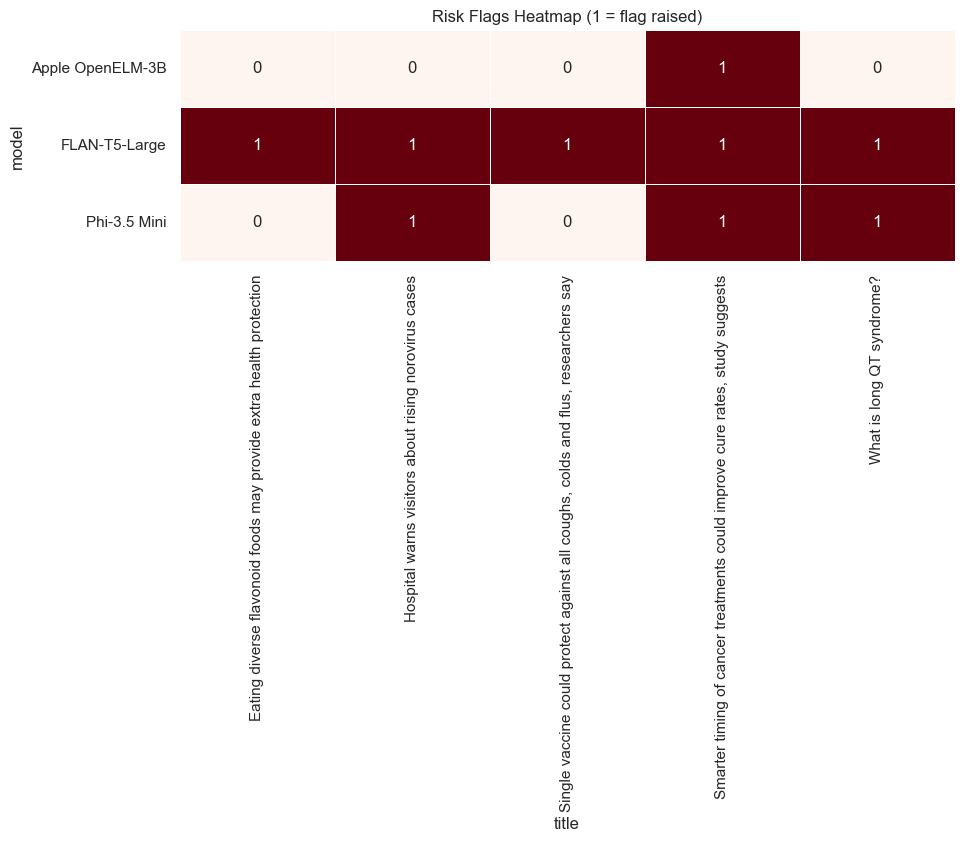

In [21]:
pivot = all_results.pivot(index="model", columns="title", values="risk_flags")
pivot_bool = pivot.map(lambda x: 1 if x != "None" else 0)

plt.figure(figsize=(10, 3))
sns.heatmap(pivot_bool, annot=True, cmap="Reds",
            cbar=False, linewidths=0.5)
plt.title("Risk Flags Heatmap (1 = flag raised)")
plt.tight_layout()
plt.savefig("risk_heatmap.png", dpi=150)
plt.show()

### Figure 3: Word Count Distribution

- This boxplot shows summary length per model. 
- Summaries are expected to stay within the 120–180 word range.

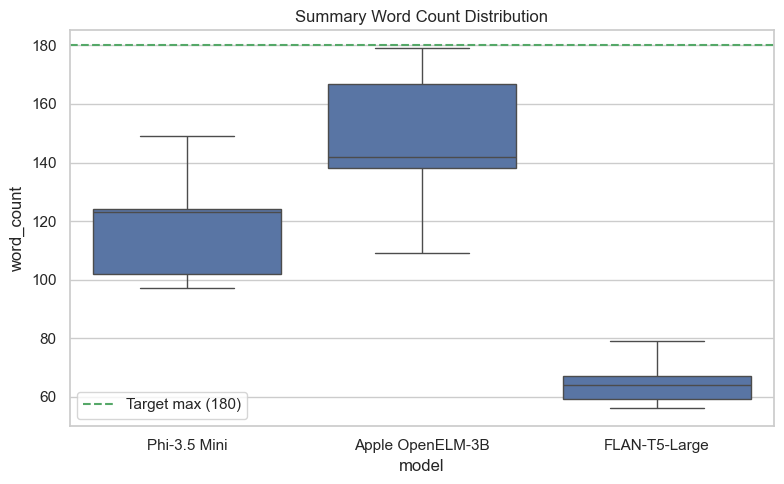

In [22]:
all_results["word_count"] = all_results["summary"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.boxplot(data=all_results, x="model", y="word_count")
plt.axhline(y=CONFIG["max_words"], color='g', linestyle='--', label=f"Target max ({CONFIG['max_words']})")
plt.title("Summary Word Count Distribution")
plt.legend()
plt.tight_layout()
plt.savefig("wordcount_boxplot.png", dpi=150)
plt.show()

### Figure 4: Lexical Diversity (Distinct-1)

- This chart measures vocabulary diversity per model. 
- Higher values indicate less repetition.

C:\Users\abedi\AppData\Local\Temp\ipykernel_4160\225168264.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=all_results, x="model", y="distinct_1", ci=None)


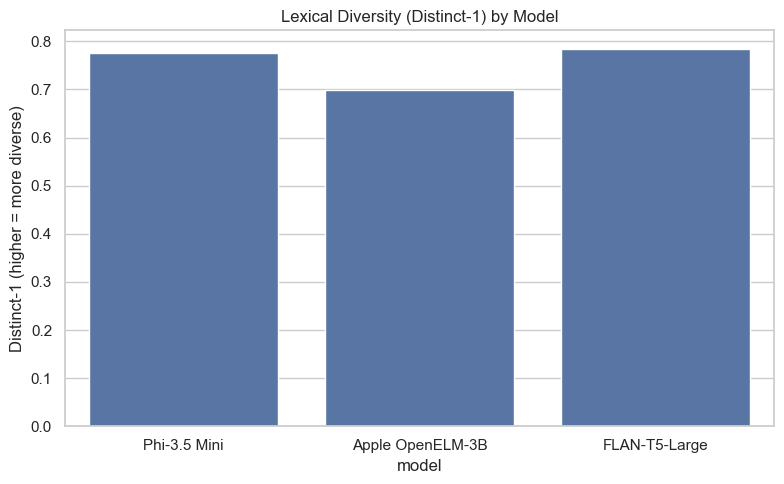

In [23]:
if "distinct_1" in all_results.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(data=all_results, x="model", y="distinct_1", ci=None)
    plt.title("Lexical Diversity (Distinct-1) by Model")
    plt.ylabel("Distinct-1 (higher = more diverse)")
    plt.tight_layout()
    plt.savefig("distinct1.png", dpi=150)
    plt.show()

In [24]:
# Final Table with Conditional Formatting

# Display table with human_review highlighted
def highlight_review(val):
    color = 'red' if val == "Yes" else 'white'
    return f'background-color: {color}'

styled = all_results.style.map(highlight_review, subset=['human_review'])  # <-- FIXED
display(styled)

,source,title,model,summary,readability_fre,risk_flags,human_review,distinct_1,distinct_2,word_count
0,BBC,"Single vaccine could protect against all coughs, colds and flus, researchers say",Phi-3.5 Mini,"Researchers at Stanford University have developed a nasal spray vaccine that could potentially protect against all respiratory infections, including coughs, colds, flus, bacterial lung infections, and even allergies. This ""universal vaccine"" represents a significant shift from traditional vaccines, which target specific infections. The vaccine works by mimicking immune cell communication, keeping macrophages on high alert in the lungs, potentially reducing viral and bacterial penetration by up to 1,000-fold. Early animal trials suggest a three-month duration of effectiveness, with additional benefits against allergens. The research, though in early stages, has garnered excitement for its potential to revolutionize respiratory infection protection. However, questions remain regarding its application in humans, including delivery methods, duration of immune response, and safety, with plans for human trials involving deliberate infection to assess immune reaction. The researchers envision a complementary role for this vaccine, possibly as a seasonal spray to provide broad immunity against common respir",5.810000,None,Yes,0.751678,0.993243,149
1,BBC,Hospital warns visitors about rising norovirus cases,Phi-3.5 Mini,"West Suffolk Hospital in Bury St Edmunds has closed Ward F9 due to a rise in norovirus cases, urging visitors to avoid the hospital if they've recently experienced symptoms like vomiting or diarrhea. The hospital has intensified cleaning and advises those with symptoms to seek alternative care, while emphasizing the importance of hand hygiene to prevent the spread of norovirus, which can be transmitted through contact with infected individuals or surfaces. The NHS Suffolk and North East Essex Integrated Care Board highlights the virus's incubation period and recommends staying home and practicing good handwashing to reduce transmission.",23.130000,"Potential overconfident medical claim, Too short (<120 words)",Yes,0.783505,0.989583,97
2,Harvard Health,Eating diverse flavonoid foods may provide extra health protection,Phi-3.5 Mini,"A study highlights the health benefits of consuming a diverse array of flavonoid-rich foods, which are compounds that give plants their vibrant colors. Participants with the highest intake variety of these foods, averaging seven types per day, experienced a 20% reduced risk of diabetes, a 10% reduced risk of cardiovascular disease, and an 8% lower risk of cancer compared to those with the lowest variety. The research suggests that a broad range of flavonoids, exceeding the 6,000 types found in plants, provides comprehensive health protection, with benefits such as improved blood pressure, lower cholesterol, and reduced inflammation. Other studies indicate that consuming at least 500 milligrams of flavonoids daily, achievable through a combination of fruits, vegetables, and tea, is associated with health benefits.",30.500000,None,Yes,0.715447,0.967213,123
3,Harvard Health,What is long QT syndrome?,Phi-3.5 Mini,"Long QT syndrome (LQTS) is a condition where the heart's muscle cells take longer than normal to recharge between beats due to malfunctioning pores or electrolyte imbalances, potentially leading to erratic heartbeats, shortness of breath, fainting, and sudden death. While most individuals with LQTS do not exhibit symptoms, certain medications, including some for heart disease, diabetes, depression, and allergies, can induce the condition. Women on antibiotics and antipsychotics are at higher risk. Genetic factors play a significant role, with three genes accounting for most inherited cases. Diagnosis often occurs incidentally through ECG tests or by evaluating medical and family history, particularly in individuals with a history of fainting triggered by physical exertion or loud noise

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
Summary of Approach
</span>
</div>

- **Approach:** Implemented HEAL-Summ-lite using three locally deployable LLMs (Phi‑3.5 Mini, Apple OpenELM‑3B, FLAN‑T5‑Large) to generate health text summaries of 120-180 words.  
- **Assumptions:** Summaries should retain key numerical data and named entities; light heuristics suffice for initial safety checks; small dataset representative for demonstration.  
- **What worked:** Readability computation and risk heuristics flagged relevant issues; table and visualizations clearly presented model differences; Apple OpenELM‑3B consistently met length requirements.  
- **What didn’t work / failure case:** FLAN‑T5 systematically produced summaries below 120 words (avg 60-79); some summaries still omitted numerical details or named entities despite heuristics.  
- **Evaluation/check:** Flesch Reading Ease (FRE) computed per summary; human review triggered for readability <50 or any risk flags.  
- **Human review rule:** Escalates summaries if readability <50, any risk flag is raised, or summary length is outside 120-180 words (via length flags).  
- **Improvements next:** Add named entity recognition (NER) for better accuracy; expand risk heuristics to check factual correctness; test on larger datasets; consider human-in-the-loop validation.  
- **Advanced metrics:** Lexical diversity (Distinct‑1/2) calculated to detect redundancy and measure richness of vocabulary.

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
Discussion of Results
</span>
</div>

## Readability
- **Apple OpenELM-3B:** Most readable (avg FRE 46) - accessible to high school readers.  
- **FLAN-T5-Large:** Moderate readability (avg FRE 45), but all summaries fell below 120 words.  
- **Phi-3.5 Mini:** Least readable (avg FRE 22), with dense medical terminology.  

## Risk Flags
- **Apple OpenELM-3B:** Conservative (1/5 texts flagged) - only the cancer summary for missing numbers.  
- **Phi-3.5 Mini:** Moderate (3/5 flagged) - issues with missing numbers, named entities, and potential overconfident.  
- **FLAN-T5-Large:** Most sensitive (5/5 flagged) - dominated by “Too short” warnings.  

## Length Compliance (120-180 words)
- **Apple OpenELM-3B:** Best adherence; summaries mostly within range.  
- **Phi-3.5 Mini:** Mixed - some too short (e.g., norovirus: 97 words).  
- **FLAN-T5-Large:** All summaries too short (avg 60-79 words).  

## Lexical Diversity (Distinct‑1)
- **FLAN-T5-Large & Phi-3.5 Mini:** High diversity (~0.78, ~0.77).  
- **Apple OpenELM-3B:** Lower diversity (~0.69) but more complete summaries.  

## Human Review
- 12/15 summaries flagged  
- Frequent triggers:  
  - Insufficient length (8×)
  - Missing numbers (7×)
  - Missing named entities (2×)
  - Potential overconfident medical claim (2×)

## Key Trade‑off
- **Apple:** Complete, readable, conservative flags.  
- **Phi:** Detailed but complex, moderate flags.  
- **FLAN-T5:** Simple but incomplete, over‑flags.

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
Project Challenges & Resolutions
</span>
</div>

- **Slow Internet:** Download errors for large models → used manual downloads.  
- **Memory Limits:** Full models exceeded RAM → used quantized GGUF / float16 models.  
- **GGUF Compatibility:** FLAN-T5 GGUF failed → switched to full Hugging Face version.  
- **Simplistic Risk Heuristic:** Missing numbers alone → added named entities & overconfident claim checks.  
- **Small Sample / No Ground Truth:** Limited texts → used readability, risk flags, and qualitative evaluation.  
- **Time Constraints:** ~3 days → prioritized working pipeline, automation, and documentation.  

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
Future Research Directions
</span>
</div>

1. **Enhanced Heuristics and Validation:** Implement named entity recognition (NER) for more accurate entity tracking; expand risk heuristics to verify factual claims against external knowledge bases; test on larger, more diverse datasets; and incorporate human-in-the-loop validation with clinical experts to refine flags and thresholds.

2. **Time-Aware RAG for Health Summarization:** Use retrieval-augmented generation to include past weekly summaries and related articles, enabling HEAL-Summ to track evolving health narratives.  

3. **Multimodal Extension for Infographics:** Incorporate information from charts and infographics using OCR to enrich health news summaries.

4. **Cancer-Subtype / Theme-Specific Summarization:** Adapt HEAL-Summ to produce targeted summaries for specific cancer types (e.g., lung, breast).

<div style="text-align:center;">
<span style="font-size:35px; font-weight:bold; color:#03bafc;">
Tool Use Disclosure
</span>
</div>

- **LLMs / Libraries Used:**  
  - `llama-cpp-python` for Phi‑3.5 Mini and Apple OpenELM‑3B  
  - Hugging Face `transformers` and `torch` for FLAN‑T5‑Large  
  - `textstat` for readability  
  - `nltk` for n‑grams / lexical diversity  
  - `pandas`, `matplotlib`, `seaborn` for data handling and visualization  
  - `tqdm` for progress bars  
  - `IPython.display` for scrollable table rendering  

- **Personally Implemented / Validated:**  
  - Summary length enforcement (120-180 words)  
  - Risk heuristics: missing numbers, missing named entities, overconfident claims  
  - Human review rule  
  - Lexical diversity metrics (Distinct‑1, Distinct‑2)  
  - Combined tables, CSV outputs, and plots  
  - Logging and intermediate saving of results

- **AI Acknowledgment:**
  - This project benefited from the use of ChatGPT for the following:
    - Code optimisation, commenting, and debugging (e.g., resolving ReadTimeout errors, memory issues, GGUF‑FLAN‑T5 incompatibility).
    - Drafting parts of the Discussion, Limitations, and Challenges sections based on my notes.
  - All core ideas, project design, data selection, heuristic definitions, metric implementation, result interpretation, and future research directions are my own.